In [1]:
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from keras.layers import *
import tensorflow as tf
import numpy as np
import model_fourier as model

c:\Users\phong\.conda\envs\tf\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.12.2 when it was built against 1.12.1, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


## Data preparation

In [2]:
no_of_sensor = 16
# Prepare field data
Re_list_train = [300, 400, 450, 500, 600, 650, 700, 800, 850, 900, 1000]
Re_list_test = [350, 550, 750, 950]

sensor_data_whole = []
full_field_data_whole = []
for Re in Re_list_train:
    filename = "E:/Research/Data/flow_field_recon/random_sensor_data/sensor_data_" + str(no_of_sensor) + "_" + str(Re) + ".npy"
    sensor_data = np.load(filename)
    sensor_data_whole.append(sensor_data)
    filename_field = "E:/Research/Data/flow_field_recon/full_field_data/full_field_data_" + str(Re) + ".npy"
    full_field_data_whole.append(np.load(filename_field))

sensor_data_whole_array = np.swapaxes(np.concatenate(sensor_data_whole,axis = -1), 0,1)
full_field_data_whole_array = np.swapaxes(
    np.expand_dims(
        np.concatenate(full_field_data_whole, axis = -1), axis = 0),
        0, -1)

print(sensor_data_whole_array.shape)
print(full_field_data_whole_array.shape)

# Normalization

min_val = np.amin(full_field_data_whole_array)
max_val = np.amax(full_field_data_whole_array)
full_field_data_whole_array_norm = (full_field_data_whole_array - min_val)/(max_val - min_val)
sensor_data_whole_array_norm = (sensor_data_whole_array - min_val)/(max_val - min_val)

# Test
print("Check field data: ", np.amin(full_field_data_whole_array_norm), np.amax(full_field_data_whole_array_norm))
print("Check sens data: ", np.amin(sensor_data_whole_array_norm), np.amax(sensor_data_whole_array_norm))

dim = full_field_data_whole_array_norm.shape
x = tf.linspace(0, 1, dim[2])
y = tf.linspace(0, 1, dim[1])
coordX, coordY = np.meshgrid(x, y)
coordX = np.expand_dims(coordX, axis = -1)
coordY = np.expand_dims (coordY, axis = -1)
input_coord = np.concatenate([coordX,coordY], axis = -1)
input_coord = np.repeat(input_coord[np.newaxis,:,:,:], dim[0], axis = 0)
# Create tf.dataset
dataset = tf.data.Dataset.from_tensor_slices((full_field_data_whole_array_norm, input_coord))
dataset = dataset.shuffle(buffer_size = 2192) 
dataset = dataset.batch(8)
print(dataset)


(429, 16)
(429, 128, 256, 1)
Check field data:  0.0 1.0
Check sens data:  0.008671743526994664 0.7910632602340727
<BatchDataset element_spec=(TensorSpec(shape=(None, 128, 256, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 128, 256, 2), dtype=tf.float64, name=None))>


In [23]:

input_coord.shape

(429, 128, 256, 2)

In [ ]:
# Prepare sensor data


## Training

In [ ]:
tf.keras.backend.clear_session()
flow_recon_net = model.VAE()
flow_recon_net.encoder.load_weights('encoder_fourier.h5')
flow_recon_net.decoder.load_weights('decoder_fourier.h5')
flow_recon_net.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.000005, beta_1 = 0.9, beta_2 = 0.999))
flow_recon_net.fit(dataset, epochs = 100, shuffle = True)

In [4]:
x = tf.linspace(0, 256, 256)
y = tf.linspace(0,128, 128)
coordX, coordY = tf.meshgrid(x, y)
input_coord = tf.concat([coordX,coordY], axis = -1)

In [5]:
tf.shape(input_coord)

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([128, 512])>

In [5]:
# Save model weight
flow_recon_net.encoder.save_weights('encoder_fourier.h5')
flow_recon_net.decoder.save_weights('decoder_fourier.h5')

In [ ]:
tf.keras.backend.clear_session()
flow_recon_net = model.FLRNet(n_sensor = no_of_sensor)
flow_recon_net.encoder.load_weights('E:/Research/Physics-informed-machine-learning/weights/encoder.h5')
flow_recon_net.decoder.load_weights('E:/Research/Physics-informed-machine-learning/weights/decoder.h5')
flow_recon_net.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001, beta_1 = 0.9, beta_2 = 0.999))
flow_recon_net.fit(dataset, epochs = 1250, shuffle = True)

In [4]:
filename = 'mapping_' + str(no_of_sensor) + '_ran_w_per.h5'
flow_recon_net.sens_mapping.save_weights(filename)

In [6]:
# Save model weight
# Prepare field data

Re_list_train = [300, 400, 450, 500, 600, 650, 700, 800, 850, 900, 1000]
Re_list_test = [350, 550, 750, 950]

sensor_data_whole = []
full_field_data_whole = []
for Re in Re_list_test:
    filename = "E:/Research/Data/flow_field_recon/random_sensor_data/sensor_data_" + str(no_of_sensor) + "_" + str(Re) + ".npy"
    sensor_data = np.load(filename)
    sensor_data_whole.append(sensor_data)
    filename_field = "E:/Research/Data/flow_field_recon/full_field_data/full_field_data_" + str(Re) + ".npy"
    full_field_data_whole.append(np.load(filename_field))

sensor_data_whole_test = np.swapaxes(np.concatenate(sensor_data_whole,axis = -1), 0,1)
full_field_data_whole_test = np.swapaxes(
    np.expand_dims(
        np.concatenate(full_field_data_whole, axis = -1), axis = 0),
        0, -1)

print(sensor_data_whole_test.shape)
print(full_field_data_whole_test.shape)

full_field_data_whole_test_norm = (full_field_data_whole_test - min_val)/(max_val - min_val)
sensor_data_whole_test_norm = (sensor_data_whole_test - min_val)/(max_val - min_val)

# Test
print("Check field data: ", np.amin(full_field_data_whole_test_norm), np.amax(full_field_data_whole_test_norm))
print("Check sens data: ", np.amin(sensor_data_whole_test_norm), np.amax(sensor_data_whole_test_norm))

(156, 16)
(156, 128, 256, 1)
Check field data:  0.0 0.9929987273789493
Check sens data:  0.017918539916810732 0.7385736236309344


In [7]:
# Save model weight
# Reconstruction
    ## FLRNet
case_idx = 2
_, _, z_sens = flow_recon_net.sens_mapping(sensor_data_whole_test_norm[39*case_idx:(39*(case_idx +1)),:])
reconstruction_sens = flow_recon_net.decoder(z_sens).numpy()



AttributeError: 'VAE' object has no attribute 'sens_mapping'

In [8]:
# Save model weight
# Reconstruction
    ## FLRNet
case_idx = 3
_, _, z_sens = flow_recon_net.encoder([full_field_data_whole_test_norm[39*case_idx:(39*(case_idx +1)),:,:,:],input_coord[39*case_idx:(39*(case_idx +1)),:,:,:]])
reconstruction_sens = flow_recon_net.decoder([z_sens, input_coord[39*case_idx:(39*(case_idx +1)),:,:,:]]).numpy()



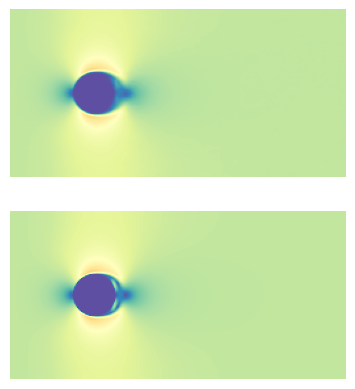

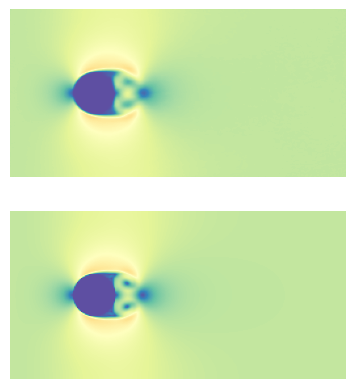

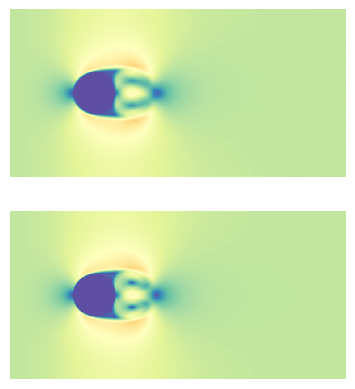

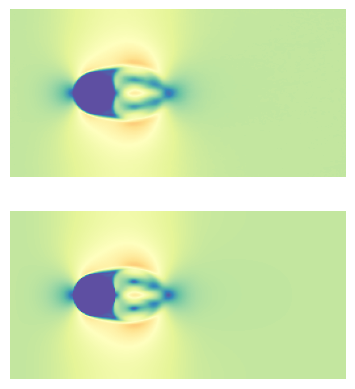

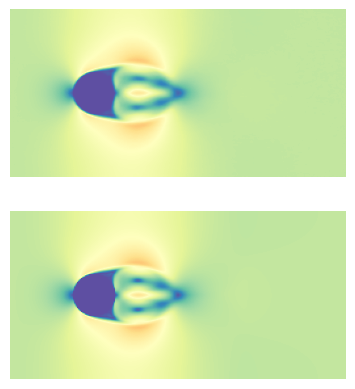

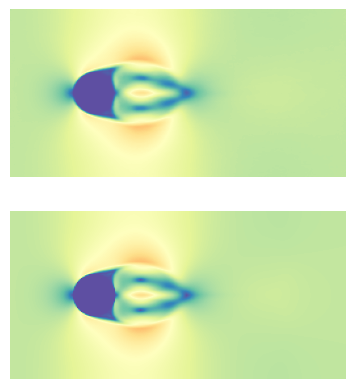

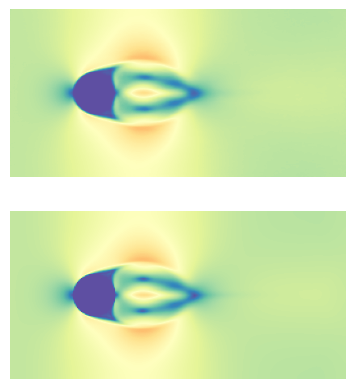

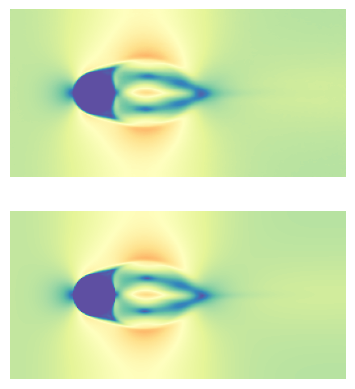

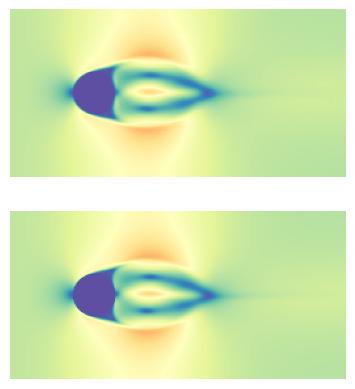

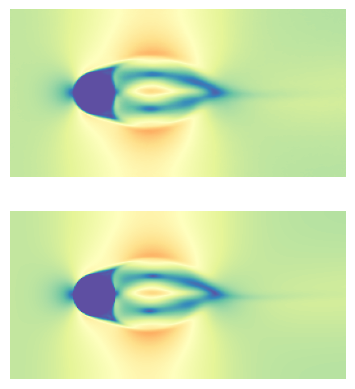

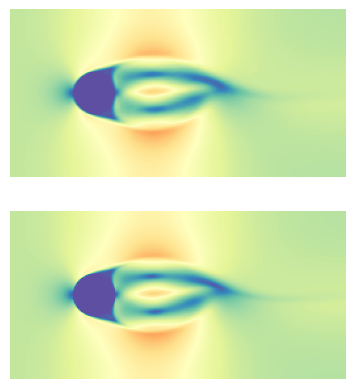

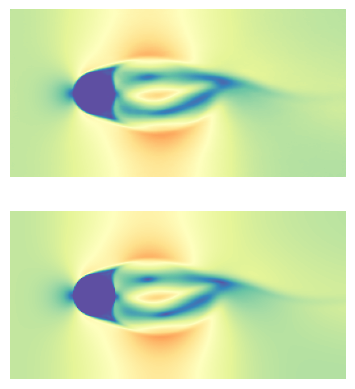

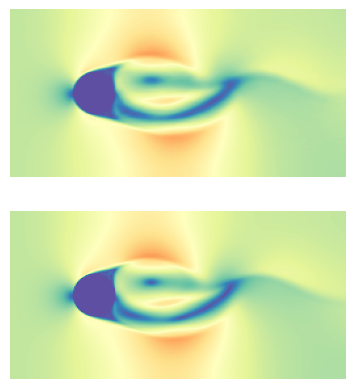

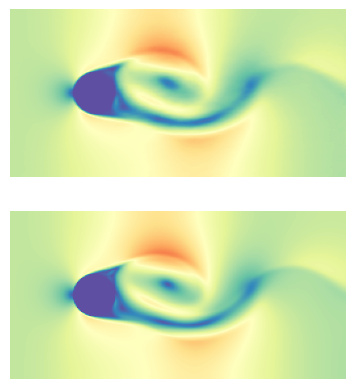

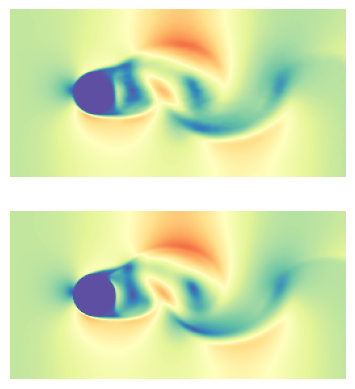

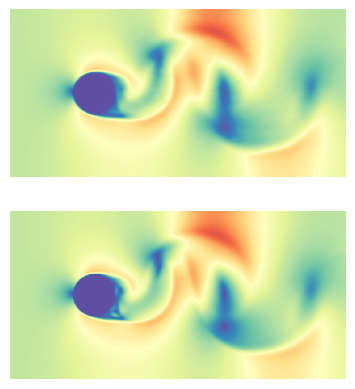

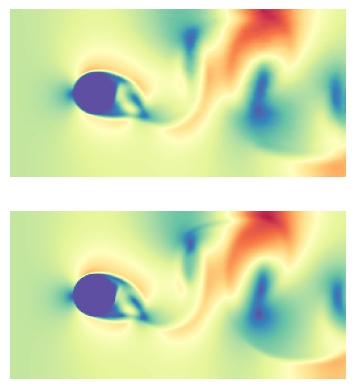

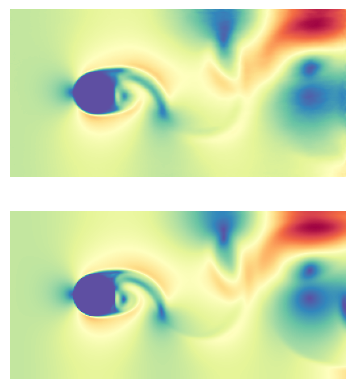

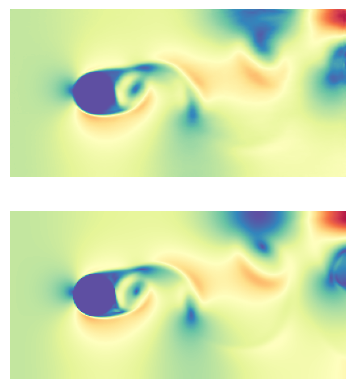

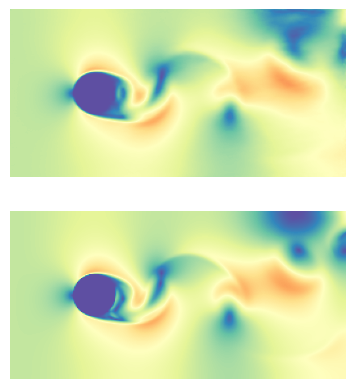

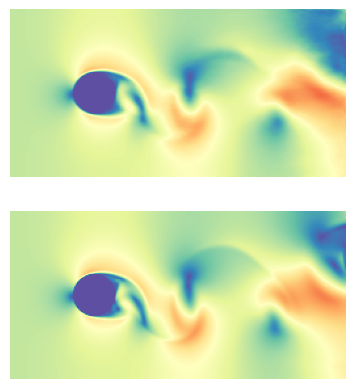

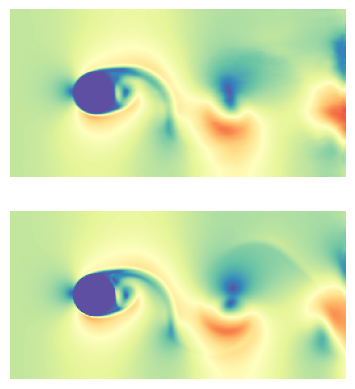

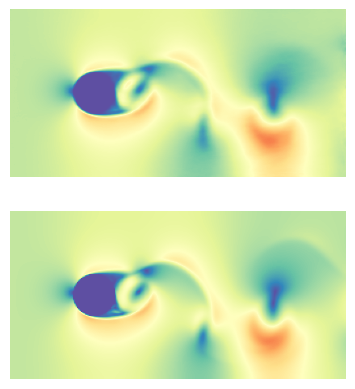

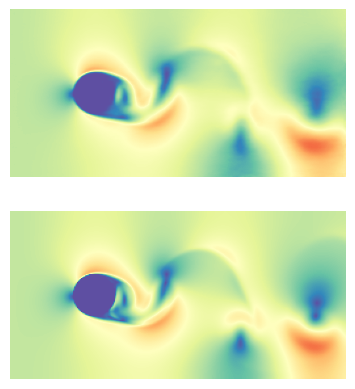

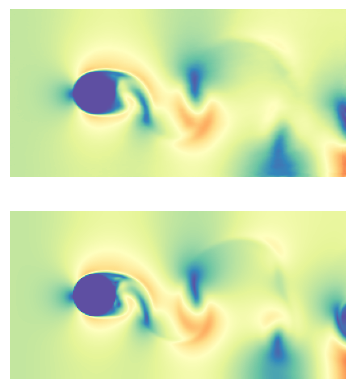

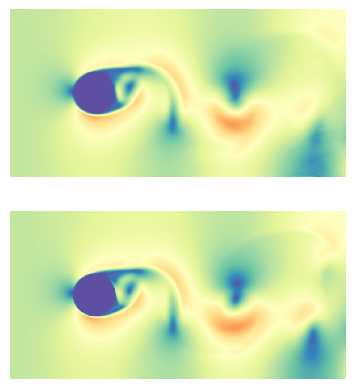

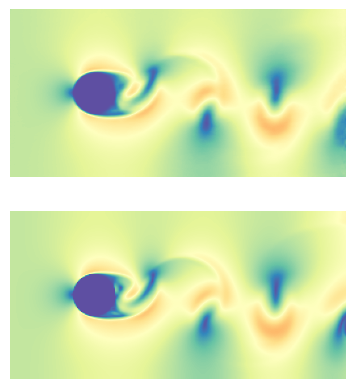

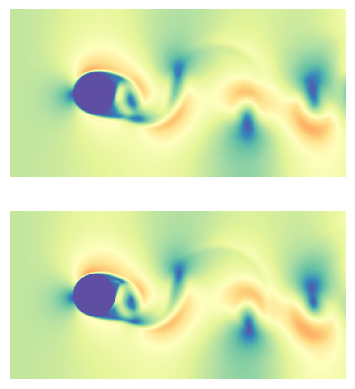

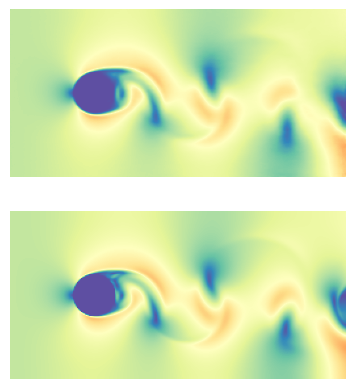

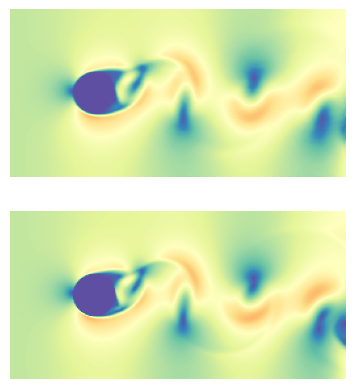

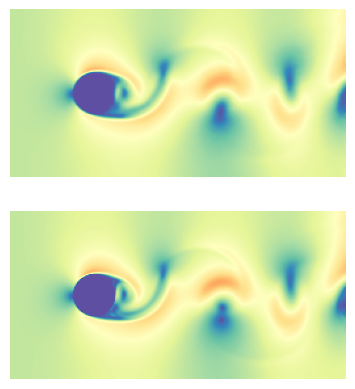

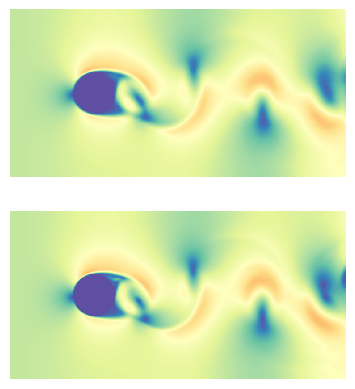

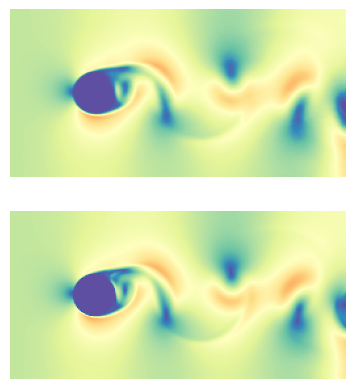

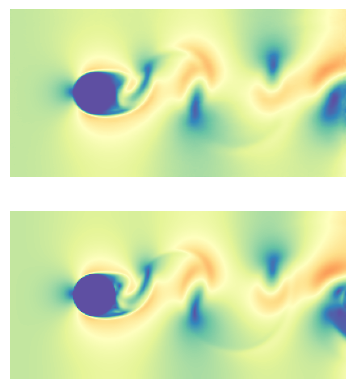

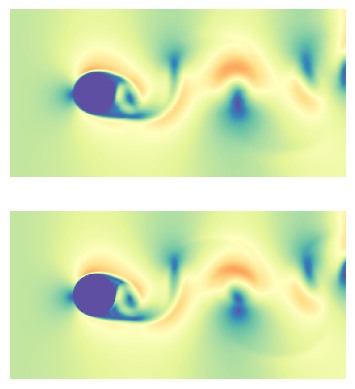

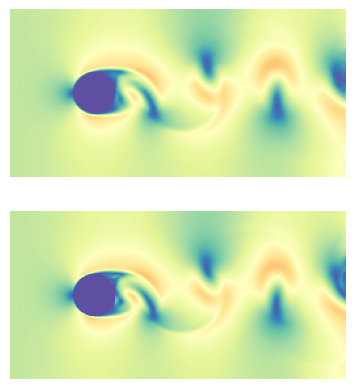

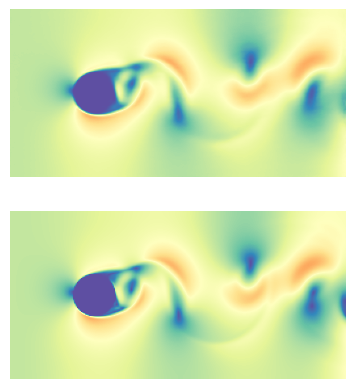

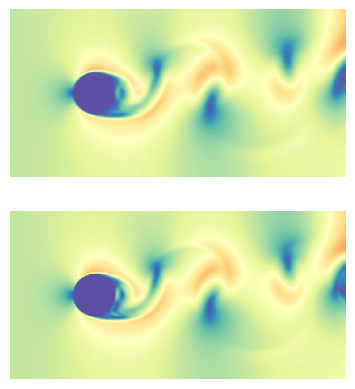

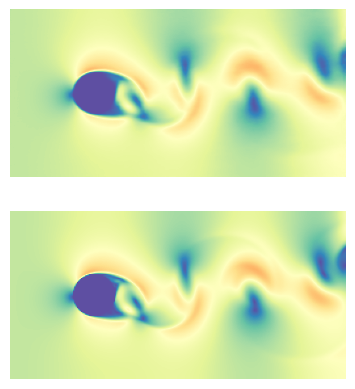

In [9]:
import matplotlib.pyplot as plt
for i in range(39):
    _, ax = plt.subplots(2,1)
    ax[0].imshow(reconstruction_sens[i,:,:,0], vmin= 0 ,vmax = 1, cmap = 'Spectral_r')
    ax[0].axis("off")
    ax[1].imshow(full_field_data_whole_test_norm[i+39*case_idx,:,:,0], vmin= 0 ,vmax = 1,cmap = 'Spectral_r')
    ax[1].axis("off")
    plt.show()